### ModelOne + ADSTuner + Deploy Model

* Notebook da utilizzare per il deploy del modello

data from: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

In [1]:
import gc

import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

### leggiamo l'intero LARGE dataset

In [2]:
cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

In [3]:
# removed ip because it is high card
feat = ['ip', 'app', 'device', 'os', 'channel']
cat_feat = ['app', 'device', 'os', 'channel']

In [4]:
# adding new features

def add_new_features(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    
    print('group by : ip_app_channel_var_day')
    gp = df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_hour_count_chl')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    df = df.merge(gp, on=['ip','day','hour'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_count_chl')
    gp = df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    df = df.merge(gp, on=['ip','app'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_count_chl')
    gp = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_chl_var_hour')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'qty_var'})
    df = df.merge(gp, on=['ip','day','channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_var_hour')
    gp = df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_chl_mean_hour')
    gp = df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    return df

In [5]:
# save for faster restart
# orig_train.to_feather("train_augmented")

### Restart Point !!!

In [7]:
%%time

# per serializzare il risultato della Feature Engineering conviene NOn usare csv ed usare formagti compressi, io ho usato feather
# ma avrei potuto usare Parquet

orig_train = pd.read_feather("train_augmented.fea")

CPU times: user 8.69 s, sys: 6.64 s, total: 15.3 s
Wall time: 3.15 s


In [8]:
orig_train.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,ip_app_channel_var_day,qty,ip_app_count,ip_app_os_count,qty_var,ip_app_os_var,ip_app_channel_mean_hour
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,6,0.914338,1,5427,1326,7.893333,38.855403,8.619632
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,6,0.745750,1,5025,1380,9.618462,26.386922,8.090909
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,6,0.690244,1,2012,442,15.600000,34.029284,8.317073
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,6,0.883721,1,9474,1954,5.947712,39.259411,10.477273
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,6,0.619048,1,232,80,10.800000,37.221361,11.428571


* il dataset è estremamente sbilanciato... andrebbe fatto downsampling della classe 0
* il downsampling lo faccio dopo lo split train validation

In [9]:
TARGET = 'is_attributed'

# train, validation split
TRAIN_FRAC = 0.98

N_TRAIN = int(orig_train.shape[0] * TRAIN_FRAC)

# shuffle
orig_train = orig_train.sample(frac=1.)

df_train = orig_train[:N_TRAIN]
df_valid = orig_train[N_TRAIN:]

print('Original training samples:', df_train.shape[0])
print('Num. validation samples:', df_valid.shape[0])

Original training samples: 181205812
Num. validation samples: 3698078


In [10]:
# rebalance

feat = ['ip', 'app', 'device', 'os', 'channel',
       'hour', 'day', 'ip_app_channel_var_day', 'qty', 'ip_app_count',
       'qty_var', 'ip_app_os_count', 'ip_app_os_var',
       'ip_app_channel_mean_hour']

# removed ip because it is high cardinality
cat_feat = ['app', 'device', 'os', 'channel']

x_train = df_train[feat]
y_train = df_train[TARGET]

x_valid = df_valid[feat]
y_valid = df_valid[TARGET]

# faccio downsampling della classe "negativi"
rus = RandomUnderSampler(random_state=0)

x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

#### Final training con i parametri ottenuti con ADSTuner

In [11]:
%%time

# parametri dall'ottimizzazione con ADSTuner

model = lgb.LGBMClassifier(objective='binary', seed=4321, n_jobs=-1, n_estimators=100, num_leaves = 48, max_depth=20, early_stopping_rounds=10)

best_model = model.fit(x_train_resampled, y_train_resampled, eval_set=[(x_valid, y_valid)], verbose=1, feature_name=feat, categorical_feature=cat_feat, eval_metric = 'auc')

/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'device', 'os']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.965808	valid_0's binary_logloss: 0.620043
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.967051	valid_0's binary_logloss: 0.559494
[3]	valid_0's auc: 0.96748	valid_0's binary_logloss: 0.508645
[4]	valid_0's auc: 0.967489	valid_0's binary_logloss: 0.465383
[5]	valid_0's auc: 0.967846	valid_0's binary_logloss: 0.428359
[6]	valid_0's auc: 0.968211	valid_0's binary_logloss: 0.396442
[7]	valid_0's auc: 0.968364	valid_0's binary_logloss: 0.368637
[8]	valid_0's auc: 0.96861	valid_0's binary_logloss: 0.344404
[9]	valid_0's auc: 0.969034	valid_0's binary_logloss: 0.32321
[10]	valid_0's auc: 0.969308	valid_0's binary_logloss: 0.304588
[11]	valid_0's auc: 0.970243	valid_0's binary_logloss: 0.288108
[12]	valid_0's auc: 0.970357	valid_0's binary_logloss: 0.273498
[13]	valid_0's auc: 0.970682	valid_0's binary_logloss: 0.260633
[14]	valid_0's auc: 0.97095	valid_0's binary_logloss: 0.249153
[15]	valid_0's auc: 0.971217	valid_0's binary_logloss: 0

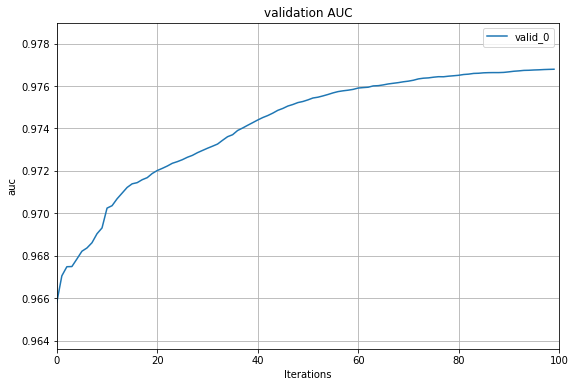

In [12]:
lgb.plot_metric(model, metric='auc', figsize=(9, 6), title='validation AUC');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

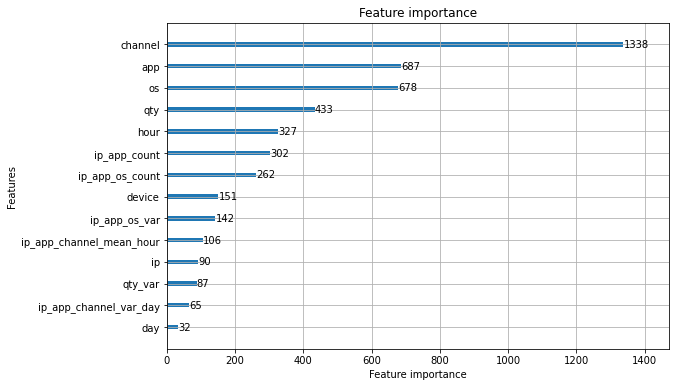

In [13]:
lgb.plot_importance(model, figsize=(9, 6), max_num_features=15)

### Prepare the Model Deployment

In [14]:
import os
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads import set_auth

import json
import pickle

In [15]:
# env and auth
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']

set_auth(auth='resource_principal')

In [16]:
# 1. prepare artifacts directory

PATH_ARTEFACT = f"./model-files"

if not os.path.exists(PATH_ARTEFACT):
    os.mkdir(PATH_ARTEFACT)

In [17]:
# 2. serialize model

pickle.dump(best_model, open(PATH_ARTEFACT + '/model.pkl', 'wb'))

In [18]:
# test: reload
test_model = pickle.load(open(PATH_ARTEFACT + '/model.pkl', 'rb'))

In [19]:
# 3. prepare deploy to Model Catalog
artifact = prepare_generic_model(PATH_ARTEFACT, function_artifacts=False, force_overwrite=True, data_science_env=True)

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


In [20]:
# reload the model
loaded_model = pickle.load(open("./model-files/model.pkl", "rb"))

In [21]:
%%writefile {PATH_ARTEFACT}/score.py

#
# customize and save score.py
#
import pandas as pd
import numpy as np
import time

import lightgbm as lgb

import pickle
import json
import os
import io
import logging 

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

# it is loaded in load_model()
model_file_name = "model.pkl"

# to enable/disable detailed logging
DEBUG = True

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    
    # Load the model from the model_dir using the appropriate loader
    
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = pickle.load(file) 
            logger_pred.info("Loaded model...")
       
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model

def preprocess_data(x):
    logger_pred.info("Eventually preprocessing and adding features...")
    
    return x
    
def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    # model contains the model and the scaler
    logger_pred.info("In predict...")
    
    # some check
    assert model is not None, "Model is not loaded"
    
    logger_feat.info('Raw input is:')
    logger_feat.info(data)
    
    x = pd.read_json(io.StringIO(data)).values
    
    if DEBUG:
        logger_feat.info("Logging features")
        logger_feat.info(x)
    
    # preprocess data (for example normalize features)
    x = preprocess_data(x)

    logger_pred.info("Invoking model......")
    
    preds = model.predict_proba(x)
    
    # rounded
    preds = np.round(preds[:, 1], 4)
    preds = preds.tolist()
    
    logger_pred.info("Logging predictions")
    logger_pred.info(preds)
    
    return { 'prediction': preds }

Overwriting ./model-files/score.py


### Test before deployment

In [22]:
%load_ext autoreload

%autoreload 2

# add the path of score.py: 

import sys 
sys.path.insert(0, PATH_ARTEFACT)

from score import load_model, predict

# Load the model to memory 
_ = load_model()

INFO:model-prediction:Loaded model...
INFO:model-prediction:Loaded model...


In [23]:
# feat = ['ip', 'app', 'device', 'os', 'channel',
#       'hour', 'day', 'ip_app_channel_var_day', 'qty', 'ip_app_count',
#       'qty_var', 'ip_app_os_count', 'ip_app_os_var',
#       'ip_app_channel_mean_hour']

# first row of origin_train
x_input = np.array([[59125, 14, 1, 25, 489, 22, 8, 0.643, 704, 1368, 55.77, 32, 43.3, 10.36],
                   [59125, 14, 1, 25, 489, 22, 8, 0.643, 704, 1368, 55.77, 32, 43.3, 10.36]])

In [24]:
predictions_test = predict(json.dumps(x_input.tolist()), _)

INFO:model-prediction:In predict...
INFO:input-features:Raw input is:
INFO:input-features:[[59125.0, 14.0, 1.0, 25.0, 489.0, 22.0, 8.0, 0.643, 704.0, 1368.0, 55.77, 32.0, 43.3, 10.36], [59125.0, 14.0, 1.0, 25.0, 489.0, 22.0, 8.0, 0.643, 704.0, 1368.0, 55.77, 32.0, 43.3, 10.36]]
INFO:input-features:Logging features
INFO:input-features:[[5.9125e+04 1.4000e+01 1.0000e+00 2.5000e+01 4.8900e+02 2.2000e+01
  8.0000e+00 6.4300e-01 7.0400e+02 1.3680e+03 5.5770e+01 3.2000e+01
  4.3300e+01 1.0360e+01]
 [5.9125e+04 1.4000e+01 1.0000e+00 2.5000e+01 4.8900e+02 2.2000e+01
  8.0000e+00 6.4300e-01 7.0400e+02 1.3680e+03 5.5770e+01 3.2000e+01
  4.3300e+01 1.0360e+01]]
INFO:model-prediction:Eventually preprocessing and adding features...
INFO:model-prediction:Invoking model......
INFO:model-prediction:Logging predictions
INFO:model-prediction:[0.075, 0.075]


In [25]:
# Saving the model artifact to the model catalog.
catalog_entry = artifact.save(display_name='model-large', 
              description='A model for fraud detection with a large dataset')

INFO:ADS:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/model-files",
  "training_script": "None"
}


In [26]:
catalog_entry.id

'ocid1.datasciencemodel.oc1.eu-frankfurt-1.amaaaaaa3mg5kzaafwegxwto2eygpme5yfuswfzn4c7xifz22itwi2lnkwpa'